# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski [2.5 pkt]
4. Jakość kodu [0.5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [1]:
learning_amount = 10000
validation = 2000
learning = 7000
testing = 1000

In [2]:
from abc import abstractmethod, ABC
from typing import List
from sklearn.datasets import fetch_openml
import numpy as np
import copy
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1)

x,y = (mnist.data, mnist.target)
# Convert labels to integers (optional)
y = y.astype(int)

# Normalize the features (optional: scale pixel values to range [0, 1])
x = x / 255.0
x_learning, label_learning = np.array(x[:(learning)]), np.array(y[:(learning)])
x_validation, label_validation = np.array(x[(learning):(learning+validation)]), np.array(y[(learning):(learning+validation)])
x_testing, label_testing = np.array(x[(learning+validation):(learning+validation+testing)]), np.array(y[(learning+validation):(learning+validation+testing)])

print("Shape of X (features):", x.shape)
print("Shape of y (labels):", y.shape)
print("Shape of Xl (features):", x_learning.shape)
print("Shape of yl (labels):", label_learning.shape)
print("Shape of Xv (features):", x_validation.shape)
print("Shape of yv (labels):", label_validation.shape)
print("Shape of Xt (features):", x_testing.shape)
print("Shape of yt (labels):", label_testing.shape)

Shape of X (features): (70000, 784)
Shape of y (labels): (70000,)
Shape of Xl (features): (7000, 784)
Shape of yl (labels): (7000,)
Shape of Xv (features): (2000, 784)
Shape of yv (labels): (2000,)
Shape of Xt (features): (1000, 784)
Shape of yt (labels): (1000,)


In [3]:
def one_hot_encode(labels: np.ndarray, num_classes: int) -> np.ndarray:
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot


In [4]:
class Layer(ABC):
    """Basic building block of the Neural Network"""
    def __init__(self) -> None:
        self._learning_rate = 0.05

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert 0 < learning_rate < 1, f"Learning rate must be in (0, 1). Got: {learning_rate}"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
        self.bias = np.random.randn(output_size) * 0.01
        self.input = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return x @ self.weights + self.bias

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        if output_error_derivative.ndim == 1:
            output_error_derivative = output_error_derivative.reshape(1, -1)

        if self.input.ndim == 1:
            self.input = self.input.reshape(1, -1)

        importance_gradient = self.input.T @ output_error_derivative
        importance_gradient = np.clip(importance_gradient, -1.0, 1.0)

        bias_gradient = np.sum(output_error_derivative, axis=0, keepdims=False)
        bias_gradient = np.clip(bias_gradient, -1.0, 1.0)

        input_error_derivative = output_error_derivative @ self.weights.T

        self.weights -= self.learning_rate * importance_gradient
        self.bias -= self.learning_rate * bias_gradient

        return input_error_derivative

class LeakyReLU(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.input = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.where(x < 0, 0.01 * x, x)

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        relu_derivative = np.where(self.input < 0, 0.01, 1)
        return output_error_derivative * relu_derivative

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.input = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.tanh(x)

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        tanh_derivative = 1 - np.tanh(self.input) ** 2
        return output_error_derivative * tanh_derivative

class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.output = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        sigmoid_derivative = self.output * (1 - self.output)
        return output_error_derivative * sigmoid_derivative

class Softmax(Layer):
    def forward(self, x: np.ndarray) -> np.ndarray:
        x = x - np.max(x, axis=-1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / (np.sum(exp_x, axis=-1, keepdims=True) + 1e-15)

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        return output_error_derivative

class Loss:
    def __init__(self, loss_function: callable, loss_function_derivative: callable) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        return self.loss_function(y_pred, y_true)

    def loss_derivative(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        return self.loss_function_derivative(y_pred, y_true)

class CrossEntropy(Loss):
    def __init__(self):
        super().__init__(self.cross_entropy, self.cross_entropy_derivative)

    @staticmethod
    def cross_entropy(y_pred: np.ndarray, y_true: np.ndarray) -> float:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    @staticmethod
    def cross_entropy_derivative(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        return y_pred - y_true

class Network:
    def __init__(self, layers: List[Layer], learning_rate: float) -> None:
        self.layers = layers
        self.learning_rate = learning_rate
        self.loss_func = None

        for layer in self.layers:
            layer.learning_rate = self.learning_rate

    def compile(self, loss: Loss) -> None:
        self.loss_func = loss

    def __call__(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int, verbose: int = 0, training: int = 1) -> None:
        """Fit the network to the training data."""
        assert isinstance(x_train, np.ndarray), "x_train must be a NumPy array"
        assert isinstance(y_train, np.ndarray), "y_train must be a NumPy array"

        num_classes = np.max(y_train) + 1
        y_train_one_hot = one_hot_encode(y_train, num_classes)
        accuracy_during_epoches = []
        lost_during_epoches = []
        Saved_states_learning = []
        for epoch in range(epochs):
            total_loss = 0
            correct_predictions = 0
            num_batches = len(x_train) // batch_size

            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i: i + batch_size]
                y_batch = y_train_one_hot[i: i + batch_size]

                outputs = self.__call__(x_batch)

                batch_loss = self.loss_func.loss(outputs, y_batch)
                total_loss += batch_loss

                correct_predictions += (outputs.argmax(axis=1) == y_batch.argmax(axis=1)).sum()
                if(training):
                    grad = self.loss_func.loss_derivative(outputs, y_batch)
                    for layer in reversed(self.layers):
                        grad = layer.backward(grad)
            avg_accuracy = correct_predictions / len(x_train)
            accuracy_during_epoches.append(avg_accuracy)
            lost_during_epoches.append(total_loss)
            Saved_states_learning.append(copy.deepcopy(self))
            if verbose:
                avg_loss = total_loss / num_batches

                print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")
        return accuracy_during_epoches, lost_during_epoches, Saved_states_learning

# Eksperymenty

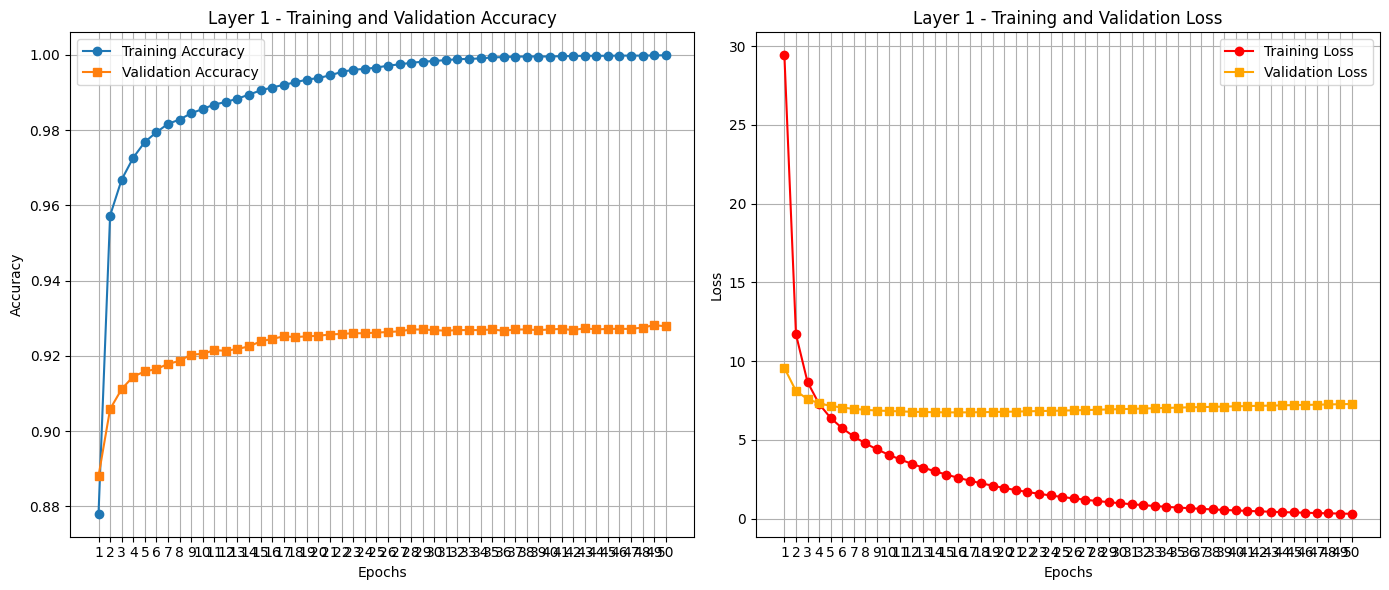

Epoch 1/1, Loss: 0.2456, Accuracy: 0.9430
our network accuracy [0.943] and our network lost [2.4556963157865774], which was achived in 15 network epoch


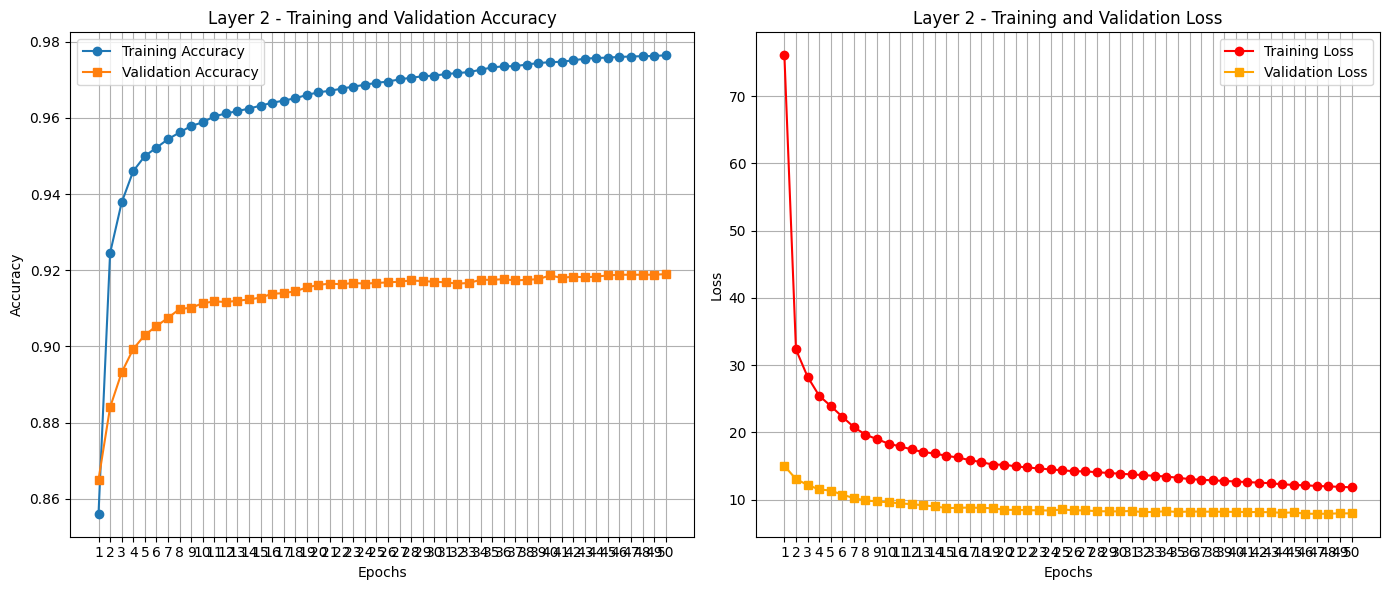

Epoch 1/1, Loss: 0.2951, Accuracy: 0.9280
our network accuracy [0.928] and our network lost [2.9506271324591893], which was achived in 46 network epoch


In [5]:
layer_accuracy = []
layer_loss = []
layers1 = [
    FullyConnected(784, 128),
    LeakyReLU(),
    FullyConnected(128, 32),
    LeakyReLU(),
    FullyConnected(32, 10),
    Softmax()
]

layers2 = [
    FullyConnected(784, 64),
    LeakyReLU(),
    FullyConnected(64, 10),
    Tanh()
]
layers = [layers1,layers2]
SEEDS = [0, 42, 100]
for layer_idx, layer in enumerate(layers):
    seed_accuracies = []
    seed_losses = []
    seed_val_accuracies = []
    seed_val_losses = []

    for seed in SEEDS:
        np.random.seed(seed)  # Set the random seed

        # Initialize network
        network = Network(layers=layer, learning_rate=0.001)
        network.compile(CrossEntropy())

        epochs = 50
        batch_size = 100

        # Train the network
        network_accuracy, network_loss, networks_saved = network.fit(
            x_train=x_learning,
            y_train=label_learning,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            training=1
        )

        # Validate the network
        network_accuracy_validation = []
        network_loss_validation = []
        network_stats = []

        for network in networks_saved:
            network_stats.append(network.fit(
                x_train=x_validation,
                y_train=label_validation,
                epochs=1,
                batch_size=batch_size,
                verbose=0,
                training=0
            ))
            network_accuracy_validation.append(network_stats[-1][0])
            network_loss_validation.append(network_stats[-1][1])

        # Store results for this seed
        seed_accuracies.append(network_accuracy)
        seed_losses.append(network_loss)
        seed_val_accuracies.append(network_accuracy_validation)
        seed_val_losses.append(network_loss_validation)

    # Average results across seeds
    avg_train_accuracy = np.mean(seed_accuracies, axis=0)
    avg_train_loss = np.mean(seed_losses, axis=0)
    avg_val_accuracy = np.mean(seed_val_accuracies, axis=0)
    avg_val_loss = np.mean(seed_val_losses, axis=0)

    # Store averaged results
    layer_accuracy.append((avg_train_accuracy, avg_val_accuracy))
    layer_loss.append((avg_train_loss, avg_val_loss))

    # Plot accuracy and loss for this layer
    epochs_range = range(1, len(avg_train_accuracy) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, avg_train_accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, avg_val_accuracy, label='Validation Accuracy', marker='s')
    plt.title(f'Layer {layer_idx + 1} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs_range)
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, avg_train_loss, label='Training Loss', marker='o', color='red')
    plt.plot(epochs_range, avg_val_loss, label='Validation Loss', marker='s', color='orange')
    plt.title(f'Layer {layer_idx + 1} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs_range)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    plt.show()
    Best_network = networks_saved[np.argmin(avg_val_loss)]

    network_testing = Best_network.fit(x_train=x_testing,
    y_train=label_testing,
    epochs=1,
    batch_size = batch_size,
    verbose=1,
    training=0)
    print(f"our network accuracy {network_testing[0]} and our network lost {network_testing[1]}, which was achived in {np.argmin(avg_val_loss)} network epoch")

# Wnioski

# Porównanie sieci z warstwami layers1 i layers2
```python 
layers1 = [
    FullyConnected(784, 128),
    LeakyReLU(),
    FullyConnected(128, 32),
    LeakyReLU(),
    FullyConnected(32, 10),
    Softmax()
]

layers2 = [
    FullyConnected(784, 64),
    LeakyReLU(),
    FullyConnected(64, 10),
    Tanh()
]
```
Sieć z warstwami layers1 okazała się lepsza, ponieważ uzyskuje lepsze wyniki w testowaniu - dokładność ~97,5%, podczas gdy druga sieć osiągnęła ~95,4% dokładności przy takiej samej liczbie epok. Co więcej, pierwsza sieć uzyskała najlepszy wynik w 15 epoce, natomiast druga w 33, co wskazuje na lepsze dostosowanie pierwszej sieci do danego zadania.
Szybsza layers1 oznacza mniejsze koszty treningu, w tym krótszy czas obliczeń i mniejsze zapotrzebowanie na zasoby. Wyższa dokładność jest również kluczowa przy wymaganej wysokiej precyzji.

# Dobór warstwy aktywacji
W trakcie poszukiwania najlepszej sieci warstwa aktywacji korzystająca z LeakyReLU okazała się najlepsza. Funkcja ta poprawia przepływ gradientów i stabilność procesu uczenia, co może mieć kluczowe znaczenie dla złożonych zadań klasyfikacyjnych.

# Dobór funkcji straty
Pierwotnie istniały dwie klasy dziedziczące po klasie straty (Loss) - klasa błędu średniokwadratowego oraz entropii krzyżowej. Zdecydowaliśmy się zostawić jedynie entropię krzyżową, ponieważ wyniki przy użytkowaniu błędu średniokwadratowego były bardzo wygórowane. Entropia krzyżowa jest lepiej dopasowana do zadań klasyfikacji, ponieważ uwzględnia prawdopodobieństwa generowane przez warstwy wyjściowe (np. Softmax). Błąd średniokwadratowy nie jest idealny dla zadań klasyfikacji.

# Efekty przeuczenia i niedouczenia
Przy pierwszej sieci można zauważyć na wykresie efekt przeuczenia (overfitting) - co może doprowadzić do gorszych wyników na nowych danych testowych. Na drugim wykresie nie widać takiego zjawiska, co oznacza, że druga sieć jest jeszcze w etapie niedouczenia (underfitting) - model nie zdążył się nauczyć wszystkich istotnych wzorców danych.

# Podsumowanie wyników
Na wykresie dokładności można zauważyć, że pierwsza sieć się nauczyła wszystkich danych wejściowych w późnych epokach, natomiast druga sieć nie zdążyła się nauczyć wszystkiego. Oznacza to, że pierwsza sieć była lepiej dostosowana do zadania, a druga wymaga dalszej optymalizacji.